<a href="https://colab.research.google.com/github/PranjalMinocha/movie_recommendation/blob/main/Complex_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Complex Movie Recommendation System**
I've used 4 features namely Director's Name, Top-3 actor names, Keywords and Genre to find similar movies.

In [ ]:
import pandas as pd
import numpy as np
from ast import literal_eval
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem.snowball import SnowballStemmer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Building Dataset**

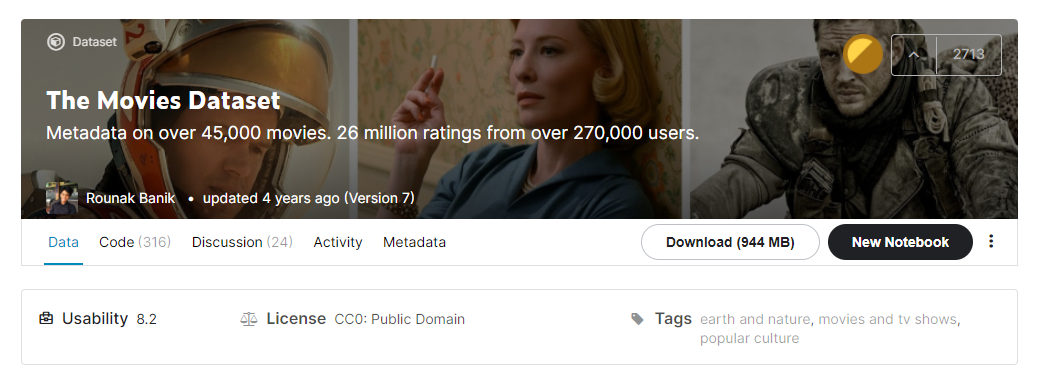

In [ ]:
# Importing movies metadata, credits and keywords
md = pd.read_csv("/content/drive/MyDrive/Python/Recommendation System/movies_metadata.csv")
credits = pd.read_csv("/content/drive/MyDrive/Python/Recommendation System/credits.csv")
keywords = pd.read_csv("/content/drive/MyDrive/Python/Recommendation System/keywords.csv")

In [ ]:
md["id"] = pd.to_numeric(md["id"], errors='coerce')
md = md.dropna(subset=['id'])
md["id"] = md["id"].astype(int)
md.shape

(45463, 24)

In [ ]:
# Merging metadata, keywords, credits
md = md.merge(credits, on='id')
md = md.merge(keywords, on='id')

In [ ]:
md.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'cast', 'crew', 'keywords'],
      dtype='object')

In [ ]:
md.drop(["adult", "belongs_to_collection", "budget", "homepage", "original_language", "original_title", "overview", "popularity", "poster_path", "production_companies", "production_countries", "release_date", "revenue", "runtime", 'spoken_languages', 'status', 'tagline', 'video', 'vote_average', 'vote_count'], axis=1, inplace=True)
md.columns

Index(['genres', 'id', 'imdb_id', 'title', 'cast', 'crew', 'keywords'], dtype='object')

In [ ]:
# Importing small dataset movie ids
links_small = pd.read_csv("/content/drive/MyDrive/Python/Recommendation System/links_small.csv")
links_small = links_small[links_small["tmdbId"].notnull()]["tmdbId"].astype(int)

In [ ]:
# Reducing dataset
smd = md[md["id"].isin(links_small)]
smd.shape

(9219, 7)

**Pre-processing**

Feature-1: Director Name

In [ ]:
# each string value to dictionary
smd["crew"] = smd["crew"].apply(literal_eval)

In [ ]:
def get_director(x):
    for i in x:
        if i["job"] == "Director":
            return i["name"]
    return np.nan

In [ ]:
# Movie's feel mostly based on Director
smd["director"] = smd["crew"].apply(get_director) 
# Removing spaces and lower casing
smd["director"] = smd["director"].astype(str).apply(lambda x: str.lower(x.replace(" ", "")))

# Weighting the director 3 times
smd["director"] = smd["director"].apply(lambda x: [x, x, x])

In [ ]:
smd["director"].head()

0          [johnlasseter, johnlasseter, johnlasseter]
1             [joejohnston, joejohnston, joejohnston]
2          [howarddeutch, howarddeutch, howarddeutch]
3    [forestwhitaker, forestwhitaker, forestwhitaker]
4          [charlesshyer, charlesshyer, charlesshyer]
Name: director, dtype: object

Feature-2: Top 3 actors

In [ ]:
# each string value to dictionary
smd['cast'] = smd['cast'].apply(literal_eval)

smd['cast'] = smd['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else []) # non-list values to empty list
smd['cast'] = smd['cast'].apply(lambda x: x[:3] if len(x) >=3 else x) # get 3 top cast

# Removing spaces and lower casing
smd['cast'] = smd['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [ ]:
smd['cast'].head()

0                  [tomhanks, timallen, donrickles]
1       [robinwilliams, jonathanhyde, kirstendunst]
2          [waltermatthau, jacklemmon, ann-margret]
3    [whitneyhouston, angelabassett, lorettadevine]
4           [stevemartin, dianekeaton, martinshort]
Name: cast, dtype: object

Feature-3: Keywords

In [ ]:
# each string value to dictionary
smd['keywords'] = smd['keywords'].apply(literal_eval)

smd['keywords'] = smd['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else []) # non-list values to empty list

In [ ]:
# counts of all keywords
s = smd.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().value_counts()

# Keywords appearing once are of no use
s = s[s > 1]

In [ ]:
# keeps keywords which are in s hence removes keyword with freq=1
def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

In [ ]:
# we use only stems of the words hence using SnowballStemmer
stemmer = SnowballStemmer('english')

In [ ]:
# each string value to dictionary
smd['keywords'] = smd['keywords'].apply(filter_keywords)
smd['keywords'] = smd['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
# Removing spaces and lower casing
smd['keywords'] = smd['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [ ]:
smd['keywords'].head()

0    [jealousi, toy, boy, friendship, friend, rival...
1    [boardgam, disappear, basedonchildren'sbook, n...
2               [fish, bestfriend, duringcreditssting]
3    [basedonnovel, interracialrelationship, single...
4    [babi, midlifecrisi, confid, age, daughter, mo...
Name: keywords, dtype: object

Feature-4: Genre

In [ ]:
# Gives all the genres
def get_genre(x):
  genres = []
  for j in x:
    genres.append(j["name"])
  return genres

In [ ]:
# each string value to dictionary
smd['genres'] = smd['genres'].apply(literal_eval)
smd["genres"] = smd["genres"].apply(get_genre)

In [ ]:
smd['genres'].head()

0     [Animation, Comedy, Family]
1    [Adventure, Fantasy, Family]
2               [Romance, Comedy]
3        [Comedy, Drama, Romance]
4                        [Comedy]
Name: genres, dtype: object

**Recommendation System**

In [ ]:
# merging keywords, cast, director, genres
smd['soup'] = smd['keywords'] + smd['cast'] + smd['director'] + smd['genres']
smd['soup'] = smd['soup'].apply(lambda x: ' '.join(x))

In [ ]:
smd['soup'].head()

0    jealousi toy boy friendship friend rivalri boy...
1    boardgam disappear basedonchildren'sbook newho...
2    fish bestfriend duringcreditssting waltermatth...
3    basedonnovel interracialrelationship singlemot...
4    babi midlifecrisi confid age daughter motherda...
Name: soup, dtype: object

In [ ]:
# applying bag of word vectorization
count = CountVectorizer(analyzer='word',ngram_range=(1, 2), stop_words='english')
count_matrix = count.fit_transform(smd['soup'])

In [ ]:
# pairwise similarity for each movie
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [ ]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [ ]:
# getting top 30 similar movies
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [ ]:
get_recommendations('Inception').head(10)

6623                             The Prestige
3381                                  Memento
4145                                 Insomnia
2085                                Following
8031                    The Dark Knight Rises
8613                             Interstellar
6981                          The Dark Knight
6218                            Batman Begins
5638    Sky Captain and the World of Tomorrow
8500                                  Don Jon
Name: title, dtype: object

In [ ]:
get_recommendations('Mean Girls').head(10)

3319               Head Over Heels
4763                 Freaky Friday
1329              The House of Yes
6277              Just Like Heaven
7905         Mr. Popper's Penguins
7332    Ghosts of Girlfriends Past
6959     The Spiderwick Chronicles
8883                      The DUFF
6698         It's a Boy Girl Thing
7377       I Love You, Beth Cooper
Name: title, dtype: object